# Predicción de la producción de energía eólica 

## Indice
* [Marco del problema](#frame_problem)
    - [Métrica](#metric)
* [Carga de datos](#load_data)
* [Análisis exploratorio](#eda)
    - [Perfil de los datos](#data_profile)
    - [Visualizando los datos](#view_data)
    - [Identificación de posibles transformaciones](#transformations_ident)
* [Preparación de los datos](#data_prepa)
    - [Limpieza de datos](#data_cleaning)
        - [Valores perdidos](#missing_values)
    - [Ingeniería de predictores](#feature_engineering)
        - [Combinación de predictores](#feature_combination)
        - [Atributos no numéricos: fechas](#non-numeric)
        - [Codificando variables cíclicas](#cyclic)
        - [Oblicuidad](#skweeness)
        - [Escalado de los datos](#scaling)
    - [Selección de predictores](#feature_selection)    
    - [Automatización de la preparación de los datos: pipeline](#pipeline)
* [Modelización](#modeling)
    - [Regresión lineal](#linear_regression)
    - [Arbol de decisión](#tree_regressor)
    - [Random Forest](#random_forest)
    - [Validación cruzada](#cross_validation)
    - [Curvas de aprendizaje](#learning-curves)
    - [Un solo predictor: la velocidad del viento](#wind-vel-only)
* [Ajuste fino del sistema](#fine_tune)
    - [Búsqueda *Grid*](#grid_search)
    - [Evaluación sobre el conjunto de test](#testing)
   
    

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

# Librerias comunes
import numpy as np
import os
import datetime as dt

# gráficas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly as pty
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

# Dónde guardar las imágenes 
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignorar warnings no útiles (SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Marco del problema
<a id="frame_problem"></a>

El objetivo es predecir con la mayor precisión posible la potencia eléctrica generada cada hora a largo de un día en una planta eólica. Se dispone de datos meteorológicos del día anterior, proporcionando valores tales como las componentes de la velocidad del viento y la temperatura del aire.

Se trata pues de un **problema de aprendizaje automático supervisado de regresión multivariante**.

### Métrica
<a id="metric"></a>

La métrica que utilizaremos para medir la precisión de las predicciones es una forma derivada del error abosluto. La denominamos *CAPE* (Cumulate Absolute Percentage Error) y viene dada por:

$$CAPE\left(\hat{Y}, Y\right) = 100 \times \frac{\sum^{N}_{i=1} \left|Y_{i} - \hat{Y}_{i}\right|}{\sum^{N}_{i=1} Y_{i}},$$

donde $N$ es el número de observaciones del conjuto de datos de test, $Y_i$, la producción observada para la hora $i$ (en MW o MW/h), y $\hat{Y}_i$ es el valor de la predicción para la hora $i$.

## Carga de datos
<a id="laod_data"></a>

In [2]:
import pandas as pd
import os

DATA_PATH = './Data/'

def load_data_train(data_path = DATA_PATH):
    csv_path = os.path.join(data_path, 'train.csv')
    return pd.read_csv(csv_path, parse_dates=['time'])

def load_data_test(data_path = DATA_PATH):
    csv_path = os.path.join(data_path, 'test.csv')
    return pd.read_csv(csv_path, parse_dates=['time'])


In [3]:
train = load_data_train()
train.tail()

FileNotFoundError: [Errno 2] File b'./Data/train.csv' does not exist: b'./Data/train.csv'

In [ ]:
test = load_data_test()
test.head()

## Análisis exploratorio
<a id="eda"></a>

### Perfil de los datos
<a id="profile_data"></a>

La librería `pandas_profiling` nos permite de manera rápida obtener una reporte muy completo del perfil de datos, simplificando el EDA considerablemente.

In [ ]:
import pandas_profiling

profile = train.profile_report(title='Report WF1')
profile.to_file(output_file="./profile_report.html")
profile

### Visualizando los datos
<a id="view_data"></a>

#### Series temporales

In [ ]:
# Copia del set de entrenamiento para no modificarlo en el EDA
wind_df = train.copy()

In [ ]:
# Visualización de las series temporales
wind_df.set_index('time').iplot(
    kind='scatter', 
    filename='cufflinks/cf-simple-line'
)

#### Correlaciones

In [ ]:
# Correlación entre variables
corr_matrix = wind_df.corr()
corr_matrix["production"].sort_values(ascending=False)

In [ ]:
# scatter plots
sns.pairplot(
    wind_df,
    diag_kind='kde',
    dropna=True
)

#### Outliers

In [ ]:
# box-plots
wind_df.drop('time', axis=1).iplot(
    subplots=True, 
    shape=(2,2),
    kind='box', 
    boxpoints='outliers',
    filename='cufflinks/box-plots'
)

### Identificación de posibles transformaciones en los predictores
<a id="transformations_ident"></a>

En base al análisis exploratorio previo, se identifican las siguientes acciones/transformaciones a realizar sobre los datos de entrenamiento:
* **Valores perdidos**: Existen 24 valores perdidos en las variables meteorológicas, los mismos para todas. Hay qué decidir si se imputan o se eliminan.
* **Outliers**: En una primera aproximación, no vamos a considerar ningún valor como anómalo, a pesar de que se observan algunos valores en las componentes del viento que podrían ser outliers. Como ejercicio futuro, dejamos el utilizar algún método para determinar si finalmente se pueden considerar outliers o no, y en caso de serlo, decidir si se eliminan o se realiza alguna transformación para resolverlos. Como dato para tomar estas decisiones, en este problema concreto es recomendable saber cual es el rango de valores de velocidad del viento para los que la turbina funciona. La mayoría de estas turbinas tienen un valor máximo para el cuál dejan de funcionar, como método de protección frente a daños.
* **Oblicuidad**: Los valores de la oblicuidad para todos los predictores están entre -0.5 y 0.5, por lo que se puede considerar que las distrubciones son mayormente simétricas. Por tanto, en principio no se tomará ninguna transformación al respecto. 
* **Combinación de predictores**: Añadiremos dos nuevos predictores que pueden ser interesantes calculados a partir de $U$ y $V$, a saber, el módulo de la velocidad y la dirección.
* **Variables no númericas**: Solo tenemos la fecha de las observaciones como variables no numéricas. Probaremos la descomposición en mes, semana, día de la semana y hora.
* **Variables cíclicas**: Para captar el comportamiento cíclico de estas variables (variables de fecha y dirección del viento) podemos mapealas en un círculo de manera que el valor más bajo esté muy próximo al más alto, para cada una de ellas  (por ejemplo, la dirección del viento para un ángulo de $0^\text{o}$ coincide con la dirección del viento para un ángulo de $360^\text{o}$).
* **Escalado/Estandarización**: Como las escalas numéricas entre los distintos predictores son diversas, podemos *estandariza* los datos, esto es, restar la media y dividir por la desviación típica en cada caso. De esta manera tendremos una distribución de media 0 y desviación típica 1 para cada predictor. Otra opción es *escala* los datos para que estén todos dentro de un mismo intervalor, por ejemplo, entre 0 y 1. Este método es más vulnerable a la presencia de outliers. 


## Preparación de los datos
<a id="data_prepa"></a>

### Limpieza de datos
<a id="data_cleaning"></a>

#### Valores perdidos
<a id="missing_values"></a>

Veamos qué porcentage de valores perdidos existe en cada caso:

In [5]:
def get_missing_percentage(df, *index_level):
    """
         It returns the percentage of missing values
         in a data frame. Optionally, it can do it grouping
         by index, if the index level is provided.
    """
    f = lambda x : round((x.isna().sum() / x.shape[0]) * 100, 2)
    if index_level:
        nans = df.groupby(level=index_level).apply(f)
    else:
        nans = df.apply(f)
    return nans

In [6]:
get_missing_percentage(wind_df)

NameError: name 'wind_df' is not defined

Identifiquemos estos valores:

In [ ]:
wind_df[wind_df['U'].isna()]

Los valores perdidos corresponden todos al día 13 de julio. Podríamos intentar imputar esos valores mediante algún método estadístico o de machine learning (por ejemplo, un ARIMA, ya que la serie cumple cierto patrón diario). Sin embargo vamos a optar por eliminar esos registros al constituir tan solo un 0.4% del total de los datos.

In [ ]:
wind_df.dropna(inplace=True)
get_missing_percentage(wind_df)

### Ingenería de predictores
<a id="feature_engineering"></a>

#### Combinación de predictores
<a id="feature_combination"></a>

Añadiremos dos nuevos predictores que pueden ser interesantes, calculados a partir de $U$ y $V$, que son las variables que parecen más correlacionadas con la producción:
* Módulo de la velocidad: $v = \left(U^2 + V^2\right)^{1/2}$.
* Dirección de la velocidad: la calculamos en base al convenio meteorológico. Para simplificar, utilizaremos la librery [`MetPy`](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_direction.html) que tiene una función que realiza este cálculo.

In [ ]:
from metpy import calc
from metpy.units import units

# Obtención del módulo de la velocidad
get_wind_velmod = lambda x : float(calc.wind_speed(
    x.U * units.meter/units.second, 
    x.V * units.meter/units.second,
).magnitude)

In [ ]:
# Obtención de la dirección (meteorológica) del viento
get_wind_dir = lambda x : float(calc.wind_direction(
    x.U * units.meter/units.second, 
    x.V * units.meter/units.second, 
    convention="from"
).magnitude)

In [ ]:
wind_df['w_vel'] = wind_df.apply(get_wind_velmod, axis=1)
wind_df['w_dir'] = wind_df.apply(get_wind_dir, axis=1)

In [ ]:
wind_df = wind_df[['time','U','V','T','w_vel','w_dir','production']]
wind_df.head()

In [ ]:
wind_df.describe()

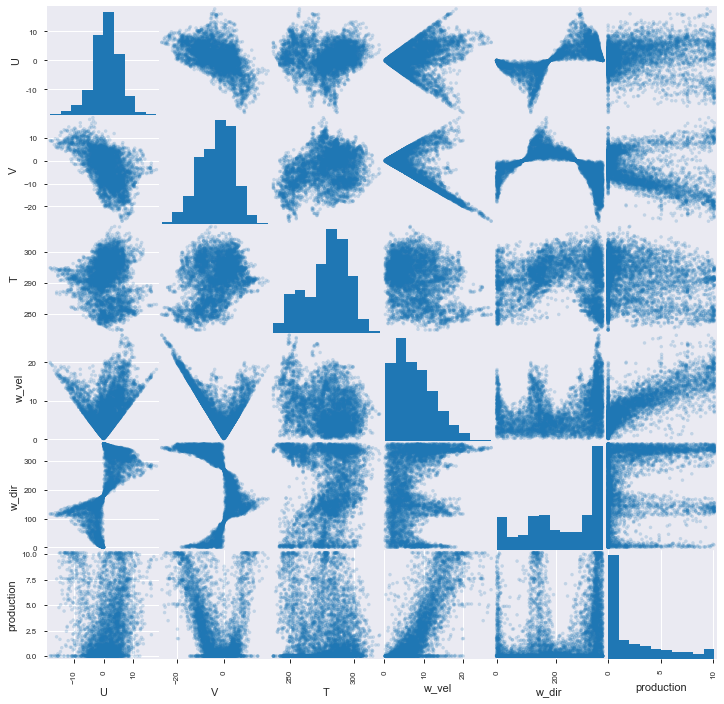

In [20]:
# scatter plots
pd.plotting.scatter_matrix(wind_df, alpha=0.2, figsize=(12, 12))
plt.show()

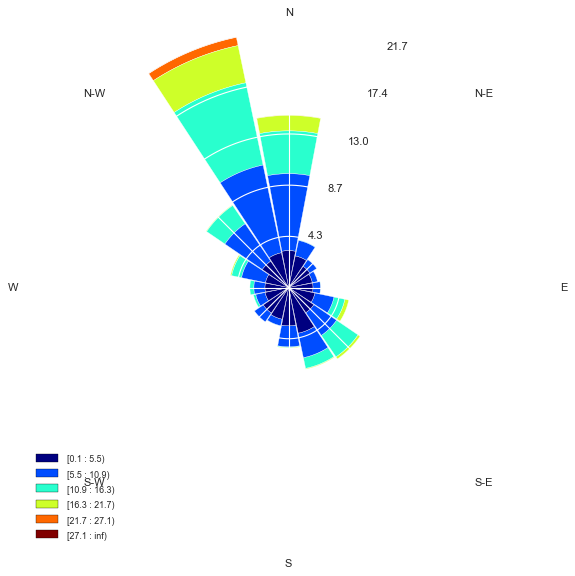

In [21]:
from windrose import WindroseAxes

ax = WindroseAxes.from_ax()
ax.bar(wind_df['w_dir'], wind_df['w_vel'], normed=True, opening=0.95, edgecolor='white')
ax.set_legend()

Vamos a recalcular las correlaciones para incluir las dos nuevas variables:

In [22]:
corr_matrix = wind_df.corr()

In [23]:
corr_matrix['production'].sort_values(ascending=False)

production    1.000000
w_vel         0.810641
w_dir         0.260782
U             0.127992
T            -0.224810
V            -0.412222
Name: production, dtype: float64

El módulo de la velocidad tiene una correlación muy alta con la producción. 

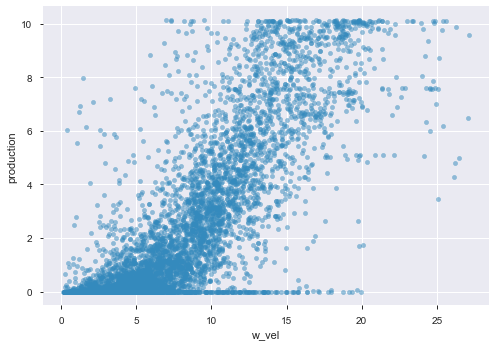

In [24]:
wind_df.plot(x='w_vel', y='production', kind='scatter', alpha=0.5)

### Atributos no numéricos
<a id="non-numric"></a>

La única variable no numérica es la fecha y hora de cada observación (columna `Time`). De cara a poder utilizar esta variable en los algoritmos de Machine Learning, podemos descomponerla en otras, como por ejemplo, mes, día de la semana y hora (el año podemos obviarlo al corresponder todas las observaciones al mismo año). Haremos esta descomposición como primera aproximación, para ver cuánto influye sobre la predicción cada una de estas componentes del tiempo. Posteriormente podemos plantearnos métodos más sofisticados como la descomposición por *wavelets*.

In [25]:
def split_date(df, date_col):
    """
        It splits datetime column of a data frame
        into new columns Month, Day and Hour.
    """
    df['month'] = df[date_col].dt.month
    df['hour'] = df[date_col].dt.hour
    df['day_of_month'] = df[date_col].dt.day
    df['day_of_week'] = df[date_col].dt.dayofweek
    return df

In [26]:
wind_df = split_date(wind_df, 'time')
wind_df = wind_df[['time', 'month','day_of_month','day_of_week','hour','U','V','T','w_vel','w_dir','production']]

In [27]:
wind_df.head()

time  month  day_of_month  day_of_week  hour      U      V  \
0 2018-05-01 01:00:00      5             1            1     1 -2.248 -3.258   
1 2018-05-01 02:00:00      5             1            1     2 -2.434 -1.446   
2 2018-05-01 03:00:00      5             1            1     3  3.365 -3.060   
3 2018-05-01 04:00:00      5             1            1     4  3.707 -6.220   
4 2018-05-01 05:00:00      5             1            1     5  3.812 -5.445   

       T     w_vel       w_dir  production  
0  286.5  3.958291   34.605437        0.02  
1  286.2  2.831126   59.286139        0.07  
2  285.8  4.548277  312.282163        0.22  
3  284.8  7.240873  329.205874        0.39  
4  284.5  6.646756  325.004449        0.41

Recalculemos la matriz de correlaciones para tener una idea de la dependencia de la producción con cada uno de los nuevos predictores.

In [28]:
corr_matrix = wind_df.corr()
corr_matrix['production'].sort_values(ascending=False)

production      1.000000
w_vel           0.810641
w_dir           0.260782
U               0.127992
hour            0.035323
day_of_week     0.015080
day_of_month   -0.086296
month          -0.130498
T              -0.224810
V              -0.412222
Name: production, dtype: float64

### Codificando variables cíclicas
<a id="cyclic"></a>
En nuestro conjunto de datos existen variables que son cíclicas, a saber:
* La hora, `hour`.
* El día de la semana, `day_of_week`
* El mes, `month`
* La dirección del viento, `w_dir`

Para captar este comportamiento cíclico podemos mapear estas variables en un círculo de manera que el valor más bajo esté muy próximo al más alto, para cada una de ellas  (por ejemplo, la dirección del viento para un ángulo de $0^\text{o}$ coincide con la dirección del viento para un ángulo de $360^\text{o}$). Calculamos las componentes $x,y$ de cada observación utilizando las funciones $\sin$ y $\cos$.

In [29]:
def transform_cyclic_attr(df):
    # Hour
    df['hr_sin'] = np.sin(df['hour'] * (2.* np.pi / 24))
    df['hr_cos'] = np.cos(df['hour'] * (2.* np.pi / 24))
    
    # Day of the week
    df['wday_sin'] = np.sin(df['day_of_week'] * (2.* np.pi / 7))
    df['wday_cos'] = np.cos(df['day_of_week'] * (2.* np.pi / 7))
    
    # Month
    df['mnth_sin'] = np.sin((df['month']-1) * (2.* np.pi / 12))
    df['mnth_cos'] = np.cos((df['month']-1) * (2.* np.pi / 12))
    
    # Wind wdir
    df['wdir_sin'] = np.sin(df['w_dir'] * (2.* np.pi / 360))
    df['wdir_cos'] = np.cos(df['w_dir'] * (2.* np.pi / 360))
    
    return df

Por conveniencia, en el caso del día de la semana y el mes, los valores van de 0 a 6 (lunes-domingo) y de 0 a 11 (enero-diciembre), respectivamente.

In [30]:
transform_cyclic_attr(wind_df)

time  month  day_of_month  day_of_week  hour      U  \
0    2018-05-01 01:00:00      5             1            1     1 -2.248   
1    2018-05-01 02:00:00      5             1            1     2 -2.434   
2    2018-05-01 03:00:00      5             1            1     3  3.365   
3    2018-05-01 04:00:00      5             1            1     4  3.707   
4    2018-05-01 05:00:00      5             1            1     5  3.812   
...                  ...    ...           ...          ...   ...    ...   
6185 2019-01-13 19:00:00      1            13            6    19  6.832   
6186 2019-01-13 20:00:00      1            13            6    20  5.977   
6187 2019-01-13 21:00:00      1            13            6    21  5.990   
6188 2019-01-13 22:00:00      1            13            6    22  5.395   
6189 2019-01-13 23:00:00      1            13            6    23  5.785   

           V      T      w_vel       w_dir  production    hr_sin    hr_cos  \
0     -3.258  286.5   3.958291   34.605437        0.02  0.258819  0.965926   
1     -1.446  286.2   2.831126   59.286139        0.07  0.500000  0.866025   
2     -3.060  285.8   4.548277  312.282163        0.22  0.707107  0.707107   
3     -6.220  284.8   7.240873  329.205874        0.39  0.866025  0.500000   
4     -5.445  284.5   6.646756  325.004449        0.41  0.965926  0.258819   
...      ...    ...        ...         ...         ...       ...       ...   
6185 -11.460  281.2  13.341957  329.198270        3.95 -0.965926  0.258819   
6186 -10.500  281.0  12.081992  330.349819        3.54 -0.866025  0.500000   
6187  -9.234  280.8  11.006673  327.028944        2.13 -0.707107  0.707107   
6188  -8.700  280.5  10.236993  328.196330        1.87 -0.500000  0.866025   
6189  -8.790  280.5  10.522848  326.649716        2.85 -0.258819  0.965926   

      wday_sin  wday_cos  mnth_sin  mnth_cos  wdir_sin  wdir_cos  
0     0.781831   0.62349  0.866025      -0.5  0.567922  0.823082  
1     0.781831   0.62349  0.866025      -0.5  0.859729  0.510751  
2     0.781831   0.62349  0.866025      -0.5 -0.739841  0.672782  
3     0.781831   0.62349  0.866025      -0.5 -0.511955  0.859012  
4     0.781831   0.62349  0.866025      -0.5 -0.573513  0.819197  
...        ...       ...       ...       ...       ...       ...  
6185 -0.781831   0.62349  0.000000       1.0 -0.512069  0.858944  
6186 -0.781831   0.62349  0.000000       1.0 -0.494703  0.869062  
6187 -0.781831   0.62349  0.000000       1.0 -0.544215  0.838946  
6188 -0.781831   0.62349  0.000000       1.0 -0.527010  0.849859  
6189 -0.781831   0.62349  0.000000       1.0 -0.549756  0.835325  

[6166 rows x 19 columns]

In [31]:
corr_matrix = wind_df.corr()
corr_matrix['production'].sort_values(ascending=False)

production      1.000000
w_vel           0.810641
mnth_cos        0.295261
w_dir           0.260782
wdir_cos        0.232987
U               0.127992
wday_cos        0.059824
hour            0.035323
day_of_week     0.015080
hr_cos         -0.008878
hr_sin         -0.051465
wday_sin       -0.052517
wdir_sin       -0.053314
mnth_sin       -0.067233
day_of_month   -0.086296
month          -0.130498
T              -0.224810
V              -0.412222
Name: production, dtype: float64

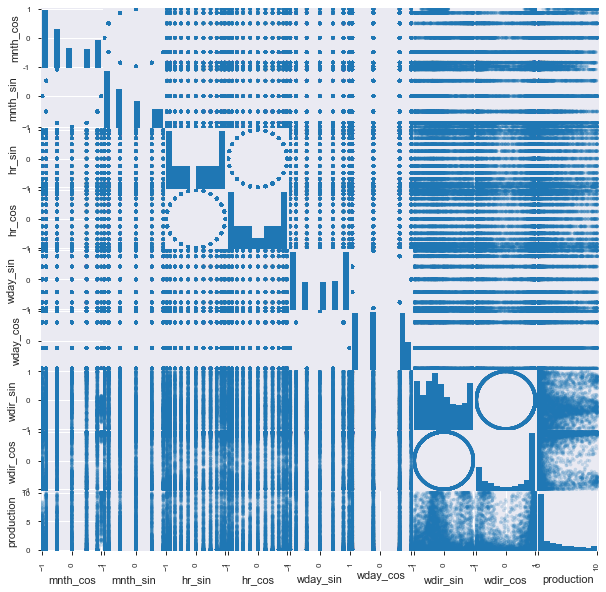

In [32]:
pd.plotting.scatter_matrix(
    wind_df[[
        'mnth_cos','mnth_sin',
        'hr_sin','hr_cos','wday_sin',
        'wday_cos','wdir_sin',
        'wdir_cos','production']], 
    alpha=0.2, 
    figsize=(10, 10)
)
plt.show()

### Oblicuidad (skewness)
<a id="outliers"></a>
Si miramos los histogramas en secciones precedentes, vemos que tanto el módulo de la velocidad, como su dirección, tienen cierta oblicuidad, una hacia la izquierda y la otra hacia la derecha. Se pueden utilizar transformaciones para eliminar la oblicuidad, como tomar el logaritmo de las observaciones.

In [33]:
wind_df.head()

time  month  day_of_month  day_of_week  hour      U      V  \
0 2018-05-01 01:00:00      5             1            1     1 -2.248 -3.258   
1 2018-05-01 02:00:00      5             1            1     2 -2.434 -1.446   
2 2018-05-01 03:00:00      5             1            1     3  3.365 -3.060   
3 2018-05-01 04:00:00      5             1            1     4  3.707 -6.220   
4 2018-05-01 05:00:00      5             1            1     5  3.812 -5.445   

       T     w_vel       w_dir  production    hr_sin    hr_cos  wday_sin  \
0  286.5  3.958291   34.605437        0.02  0.258819  0.965926  0.781831   
1  286.2  2.831126   59.286139        0.07  0.500000  0.866025  0.781831   
2  285.8  4.548277  312.282163        0.22  0.707107  0.707107  0.781831   
3  284.8  7.240873  329.205874        0.39  0.866025  0.500000  0.781831   
4  284.5  6.646756  325.004449        0.41  0.965926  0.258819  0.781831   

   wday_cos  mnth_sin  mnth_cos  wdir_sin  wdir_cos  
0   0.62349  0.866025      -0.5  0.567922  0.823082  
1   0.62349  0.866025      -0.5  0.859729  0.510751  
2   0.62349  0.866025      -0.5 -0.739841  0.672782  
3   0.62349  0.866025      -0.5 -0.511955  0.859012  
4   0.62349  0.866025      -0.5 -0.573513  0.819197

In [34]:
wind_df['log-w_vel'] = np.log1p(wind_df['w_vel'])
wind_df['log-w_dir'] = np.log1p(wind_df['w_dir'])

### Escalado de los datos
<a id="scaling"></a>
En general, salvo pocas excepciones, el rendimniento de los algoritmos de Machine Learning se ve afectado cuando la escala de los predictores es muy distinta entre ellos. Existen distintos métodos para homogeneizar la escala, pero vamos a utilizar la *estandarización*, que consiste en restar a cada observación la media de la muestra a la que pertenece y dividir por la desviación estándar. Con esto se consigue que la muestra de cada predictor tenga media 0 y desviación típica 1. 

Este método es más robusto frente a la presencia de outliers que otros.

In [35]:
for col in wind_df.drop(['time','production'], axis=1).columns:
    wind_df[col + '_stzd'] = (wind_df[col] - wind_df[col].mean())/(wind_df[col].std())


In [36]:
wind_df.filter(regex=('.+_stzd')).iplot(kind='histogram', filename='cufflinks/basic-histogram')

Podemos tambien, en lugar de estandarizarlos, escalarlos para que todos los valores estén dentro de un mismo rango, por ejemplo, entre 0 y 1.

In [37]:
lst_to_drop = list(wind_df.filter(regex='.+_stzd'))
lst_to_drop.append('production')
lst_to_drop.append('time')

for col in wind_df.drop(lst_to_drop, axis=1).columns:
    wind_df[col + '_norm'] = (wind_df[col] - min(wind_df[col]))/(max(wind_df[col]) - min(wind_df[col]))
     

In [38]:
list(wind_df.columns)

['time',
 'month',
 'day_of_month',
 'day_of_week',
 'hour',
 'U',
 'V',
 'T',
 'w_vel',
 'w_dir',
 'production',
 'hr_sin',
 'hr_cos',
 'wday_sin',
 'wday_cos',
 'mnth_sin',
 'mnth_cos',
 'wdir_sin',
 'wdir_cos',
 'log-w_vel',
 'log-w_dir',
 'month_stzd',
 'day_of_month_stzd',
 'day_of_week_stzd',
 'hour_stzd',
 'U_stzd',
 'V_stzd',
 'T_stzd',
 'w_vel_stzd',
 'w_dir_stzd',
 'hr_sin_stzd',
 'hr_cos_stzd',
 'wday_sin_stzd',
 'wday_cos_stzd',
 'mnth_sin_stzd',
 'mnth_cos_stzd',
 'wdir_sin_stzd',
 'wdir_cos_stzd',
 'log-w_vel_stzd',
 'log-w_dir_stzd',
 'month_norm',
 'day_of_month_norm',
 'day_of_week_norm',
 'hour_norm',
 'U_norm',
 'V_norm',
 'T_norm',
 'w_vel_norm',
 'w_dir_norm',
 'hr_sin_norm',
 'hr_cos_norm',
 'wday_sin_norm',
 'wday_cos_norm',
 'mnth_sin_norm',
 'mnth_cos_norm',
 'wdir_sin_norm',
 'wdir_cos_norm',
 'log-w_vel_norm',
 'log-w_dir_norm']

### Selección de predictores
<a id="feature_selection"></a>
Se pueden seleccionar los predictores de manera secuencial utilizando técnicas de Machine Learning, como
SBS y Random Forest. Existen además otras técnicas para la reducción de la dimensionalidad, como es la *extracción de features*, utilizando herramientas como el PCA o el LDA. Por otro lado, también se puede evitar el overfitting mediante técnicas de regularización en lugar de la reducción de la dimensionalidad.

En este caso vamos a utilizar un Random Forest para ver qué atributos son los más importantes.

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# separación de la variable objetivo y los predictores
wind_final_X = wind_df.drop(columns=['time', 'production'])
wind_final_Y = wind_df['production']

# creación del set de test y entrenamiento
train_x, test_x, train_y, test_y = train_test_split(wind_final_X, wind_final_Y,test_size=0.20,random_state=0)

# instanciar objeto de la clase RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# ajustar el modelo a los datos de entrenamiento
model_RFR.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

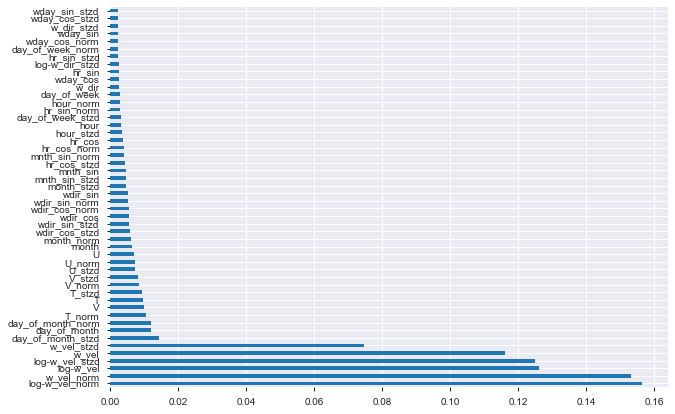

In [40]:
# Pintamos diagrama para ver la importancia de atributos
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(50).plot(kind='barh')

Basándonos en la gráfica, probamos diferentes combinaciones **razonables** de los predictores más importantes, y la que menor RMSE da es la siguiente:

In [41]:
train_x_if = train_x[['month_stzd','w_vel_stzd', 'w_dir_stzd']]
test_x_if = test_x[['month_stzd','w_vel_stzd', 'w_dir_stzd']]

model_RFR_with_if = RandomForestRegressor(max_depth=10,random_state=2)
model_RFR_with_if.fit(train_x_if, train_y)

predict_train_with_if = model_RFR_with_if.predict(train_x_if)
predict_test_with_if = model_RFR_with_if.predict(test_x_if)

print('RMSE en el set de entrenamiento: ', mean_squared_error(train_y, predict_train_with_if)**(0.5))
print('RMSE en el set de validación: ',  mean_squared_error(test_y, predict_test_with_if)**(0.5))

RMSE en el set de entrenamiento:  0.929703159795951
RMSE en el set de validación:  1.3565090245553664


## Automatización de la preparación de los datos: pipelines
<a id="pipeline"></a>

Etapas que contendrá el pipeline:
1. Creación de nuevos atributos: modulo velocidad, dirección velocidad, dia del mes, dia de la semana, hora.
2. Estandarización de atributos y borrado de columnas no necesarias.

Antes de construir el pipeline, seaparamos los atributos de la variable objetivo. Pero primero eliminamos los valores perdidos, que es nuestra estrategia de limpieza en este caso. No podemos incluirla en el pipeline ya que éste como entrada toma solo la matriz de predictores, y resultaría en una desalineación en el número de observaciones entre los predictores y la variable objetivo.

In [42]:
wind_df = train.copy()
wind_df.dropna(inplace=True)

wind_df_labels = wind_df['production']
wind_df.drop(["production"], axis=1, inplace=True)

In [43]:
wind_df.head()

time      U      V      T
0 2018-05-01 01:00:00 -2.248 -3.258  286.5
1 2018-05-01 02:00:00 -2.434 -1.446  286.2
2 2018-05-01 03:00:00  3.365 -3.060  285.8
3 2018-05-01 04:00:00  3.707 -6.220  284.8
4 2018-05-01 05:00:00  3.812 -5.445  284.5

In [44]:
# Custom transform para generar los atributos derivados de 'time' y de 'U' y 'V'
from sklearn.base import BaseEstimator, TransformerMixin

class DerivedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_wdir_attr=True):
        self.add_wdir_attr = add_wdir_attr

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        # Creamos atributos derivados de las componentes de la velocidad
        x_dataset['w_vel'] = x_dataset.apply(get_wind_velmod, axis=1)
        
        if self.add_wdir_attr:
            x_dataset['w_dir'] = x_dataset.apply(get_wind_dir, axis=1)
            
        # Creamos atributos derivados de la fecha
        x_dataset['month'] = x_dataset['time'].dt.month
        x_dataset['hour'] = x_dataset['time'].dt.hour
        x_dataset['day_of_month'] = x_dataset['time'].dt.day
        x_dataset['day_of_week'] = x_dataset['time'].dt.dayofweek
             
        return x_dataset

Automatizamos ahora los pasos de pre-procesado de datos que vamos a incluir en nuestro pipeline:
* Eliminar atributos que no se van a utilizar ('time', 'U', 'V').


In [45]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler

pre_process = ColumnTransformer(
    remainder = 'passthrough',
    transformers = [
        ('drop_columns', 'drop', ['time','U','V'])
    ]
)


Finalmente creamos el pipeline que incluye los pasos 1-3 explicados más arriba

In [46]:
from sklearn.pipeline import Pipeline

# definir pipeline
prepare_data_pipeline = Pipeline(steps=[
    ('attr_adder', DerivedAttributesAdder()), 
    ('pre_processing', pre_process),
    ('std_scaler', StandardScaler())
])


In [47]:
wind_prepared = prepare_data_pipeline.fit_transform(wind_df)

In [48]:
wind_prped_df = pd.DataFrame(data=wind_prepared,
                            index=wind_df.time,
                            columns=[
                                'T','w_vel','w_dir',
                                'month','hour','day_of_month',
                                'day_of_week'
                            ])

In [49]:
wind_prped_df.head()

T     w_vel     w_dir     month      hour  \
time                                                                    
2018-05-01 01:00:00 -0.778173 -0.752018 -1.601449 -1.125159 -1.517679   
2018-05-01 02:00:00 -0.824059 -0.979912 -1.389100 -1.125159 -1.373185   
2018-05-01 03:00:00 -0.885239 -0.632732  0.787643 -1.125159 -1.228691   
2018-05-01 04:00:00 -1.038190 -0.088334  0.933253 -1.125159 -1.084197   
2018-05-01 05:00:00 -1.084075 -0.208455  0.897104 -1.125159 -0.939703   

                     day_of_month  day_of_week  
time                                            
2018-05-01 01:00:00     -1.618817    -1.004899  
2018-05-01 02:00:00     -1.618817    -1.004899  
2018-05-01 03:00:00     -1.618817    -1.004899  
2018-05-01 04:00:00     -1.618817    -1.004899  
2018-05-01 05:00:00     -1.618817    -1.004899

## Modelización
<a id="modeling"></a>

Aplicaremos como prueba tres algoritmos: 
* Regresión lineal
* Árbol de decisión
* Random Forest

Antes definimos la función que usaremos para calcular la métrica de estos modelos:

In [50]:
# Cálculo de métrica CAPE
def get_cape(dataframe_y_true, dataframe_y_pred):
    """
    CAPE (Cumulated Absolute Percentage Error)

    Args
        dataframe_y_true: Pandas Dataframe
            Dataframe containing the true values of y.

        dataframe_y_pred: Pandas Dataframe
            Dataframe containing the predicted values of y.

    Returns
        score: Float
            The metric evaluated with the two dataframes. This must not be NaN.
    """

    # CAPE function
    cape = 100 * np.sum(np.abs(dataframe_y_pred - dataframe_y_true)) / np.sum(dataframe_y_true)

    return cape

### Regresión lineal
<a id="linear_regression"></a>

In [51]:
from sklearn.linear_model import LinearRegression

# Entrenamiento del modelo
lin_reg = LinearRegression()
lin_reg.fit(wind_prepared, wind_df_labels)

# Predicción y rendimiento
y_pred = lin_reg.predict(wind_prepared)
cape = get_cape(wind_df_labels, y_pred)
round(cape, 2)

52.61

### Arbol de decisión
<a id="tree_regressor"></a>

In [52]:
from sklearn.tree import DecisionTreeRegressor

# Entrenamiento del modelo
tree_reg = DecisionTreeRegressor()
tree_reg.fit(wind_prepared, wind_df_labels)

# Predicción y rendimiento
y_pred = tree_reg.predict(wind_prepared)
cape = get_cape(wind_df_labels, y_pred)
round(cape, 2)

0.0

Como se puede ver, existe un overfitting perfecto. Como no queremos usar el set de test hasta que no tengamos un modelo que consideremos bueno, vamos a separar el set de entrenamiento en dos partes, una para entrenar y otra para validar.

### Random Forest
<a id="random_forest"></a>

Ambos modelos tienen un CAPE alto. Probemos con un método más potente, el Random Forest, que no es más que un modelo de los denominados *ensambles*, en este caso, ensamble de árboles de decisión.

In [53]:
from sklearn.ensemble import RandomForestRegressor

# entrenamiento del modelo
forest_reg = RandomForestRegressor()
forest_reg.fit(wind_prepared, wind_df_labels)

# Predicción y rendimiento
y_pred = forest_reg.predict(wind_prepared)
cape = get_cape(wind_df_labels, y_pred)
round(cape, 2)

10.05

### Validación cruzada
<a id="corss_validation"></a>

Divideremos el set de entreanmiento en 10 subconjuntos. Se entrenará el modelo 10 veces, cada vez usando como set de validación uno de los 10 subconjuntos, y el resto como set de entrenamiento. Al final obtendremos un array con los scores obtenidos en cada caso.

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer

# creamos nuestro scorer basado en el CAPE
cape_scorer = make_scorer(get_cape, greater_is_better=False)

tree_scores = cross_val_score(
    tree_reg, 
    wind_prepared, 
    wind_df_labels,
    scoring=cape_scorer,
    cv=10
)


In [55]:
def display_scores(scores):
    print("Scores:", scores)
    print("Media:", round(scores.mean(),2))
    print("Desviación estándar:", round(scores.std(),2))

display_scores(-tree_scores)

Scores: [ 73.75410123  50.38747283  50.06966543 128.25374035  60.50225965
  51.63029869  82.65396999  58.31501636  87.83509543  67.68206033]
Media: 71.11
Desviación estándar: 22.86


El árbol de decisión resulta incluso en un peor rendimiento que la regresión lineal. Validemos otra vez la regresión lineal, pero esta vez utilizando la validación cruzada, para comparar los resultados.

In [56]:
lin_scores = cross_val_score(
    lin_reg, 
    wind_prepared, 
    wind_df_labels,
    scoring=cape_scorer,
    cv=10
)

display_scores(-lin_scores)

Scores: [61.07403648 49.15739068 50.70749849 98.32751217 60.1188395  44.04758316
 70.31428769 53.42001067 80.23306359 32.97529557]
Media: 60.04
Desviación estándar: 17.94


Veamos para el Random Forest:

In [57]:
rf_scores = cross_val_score(
    forest_reg, 
    wind_prepared, 
    wind_df_labels,
    scoring=cape_scorer,
    cv=10
)

display_scores(-rf_scores)

Scores: [56.72682444 37.43963847 40.63644964 77.78029401 48.08677075 36.16784117
 72.38776959 46.41365713 79.43376379 52.48777958]
Media: 54.76
Desviación estándar: 15.55


El que mejor resultados da, esto es, un CAPE más bajo, es el Random Forest. De cualquier forma, el error en el set de entrenamiento sigue siendo mucho menor que en el de validación, lo que quiere decir que aún sigue existiendo sobreajuste del modelo en los datos de entrenamiento.

In [58]:
# Guardar los modelos
from sklearn.externals import joblib

joblib.dump(lin_reg, "lin_reg.pkl")
joblib.dump(tree_reg, "tree_regg.pkl")
joblib.dump(forest_reg, "forest_reg")

# regresion_lineal = joblib.load("lin_reg.pkl")

['forest_reg']

## Ajuste fino del sistema
<a id="fine_tune"></a>

Existen varios métodos para encontrar la combinación más optima de los hiperparámetros del modelo (Random Forest). Utilizaremos la *búsqueda Grid*, que prueba todas las combinaciones posibles de los parámetros que se indiquen. Si el número de hiperparámetros fuera muy elevado, se recomiendan métodos como la *búsqueda aleatoria*, que va seleccionando aleatoriamente conjuntos de parámetros (no prueba todas las combinaciones posibles).

### Búsqueda *Grid*
<a id="grid_search"></a>

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(
    forest_reg, 
    param_grid, 
    cv=5,
    scoring=cape_scorer
)

grid_search.fit(wind_prepared, wind_df_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [60]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [61]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [62]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

54.79221514249726 {'max_features': 2, 'n_estimators': 3}
51.380749578255674 {'max_features': 2, 'n_estimators': 10}
50.83693924106907 {'max_features': 2, 'n_estimators': 30}
54.45373949831376 {'max_features': 4, 'n_estimators': 3}
47.88688626304638 {'max_features': 4, 'n_estimators': 10}
47.75774680079695 {'max_features': 4, 'n_estimators': 30}
54.13020539028673 {'max_features': 6, 'n_estimators': 3}
49.211312643623785 {'max_features': 6, 'n_estimators': 10}
47.59783382856819 {'max_features': 6, 'n_estimators': 30}
nan {'max_features': 8, 'n_estimators': 3}
nan {'max_features': 8, 'n_estimators': 10}
nan {'max_features': 8, 'n_estimators': 30}
51.31208933854784 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
52.782081546554465 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
53.21939520128929 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
48.5329145624675 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
54.98613082626696 {'bootstrap': False,

El mejor resultado del CAPE que obtenemos es 47.11 {'max_features': 4, 'n_estimators': 30}, que mejora  el 54.67 obtenido anteriormente con los parámetros estándar del Random Forest.

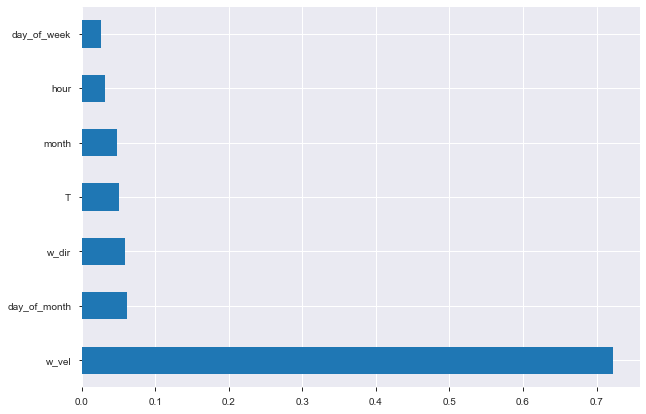

In [63]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(grid_search.best_estimator_.feature_importances_, 
                             index=[
                                 'T','w_vel','w_dir',
                                 'month','hour','day_of_month',
                                 'day_of_week'
                             ])
feat_importances.nlargest(50).plot(kind='barh')

Volvemos a comprobar, ahora sobre el modelo elegido, que la velocidad del viento es el factor más importante sobre la producción de energía eólica, con más de un 65%, seguido de la dirección y el mes de observación, con algo menos del 10% cada una. Esto puede servirnos para no considerar atributos menos importantes y simplicar de esta forma la complejidad del modelo.

### Evaluación sobre el cojunto de test
<a id="testing"></a>

In [64]:
final_model = grid_search.best_estimator_

wind_test = test.copy()
wind_test.dropna(inplace=True)
wind_test_labels = wind_test['production']
wind_test.drop(["production"], axis=1, inplace=True)
wind_pprd_test = prepare_data_pipeline.transform(wind_test)

final_predictions = final_model.predict(wind_pprd_test)
final_cape = get_cape(wind_test_labels, final_predictions)
final_cape

24.91544532130777

In [65]:
real_pred = np.concatenate((np.array(wind_test_labels), final_predictions)).reshape(49,2)

df_real_pred =  pd.DataFrame(data=real_pred,
                             index=test.time,
                             columns=['real-production','pred-production'])

In [66]:
df_real_pred.head()

real-production  pred-production
time                                                 
2019-01-14 00:00:00             3.76             4.83
2019-01-14 01:00:00             3.37             5.35
2019-01-14 02:00:00             6.21             6.39
2019-01-14 03:00:00             6.06             5.49
2019-01-14 04:00:00             4.59             5.43

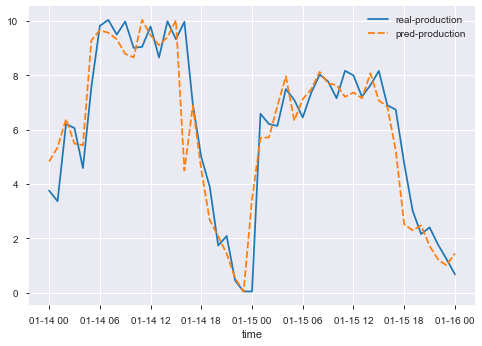

In [67]:
ax = sns.lineplot(data=df_real_pred)

### Curvas de aprendizaje
<a id="learning-curves"></a>

Examinemos como varía el error del modelo para el cojunto de entrenamiento y validación, en función del número de observaciones.

In [93]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

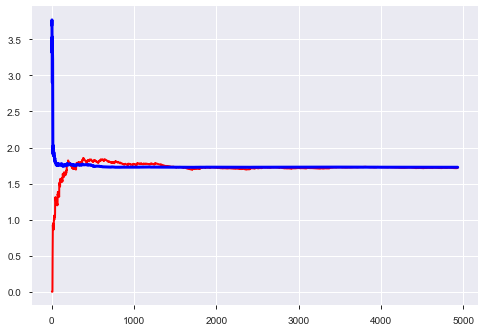

In [95]:
plot_learning_curves(lin_reg, wind_prepared, wind_df_labels)

Under-fitting!

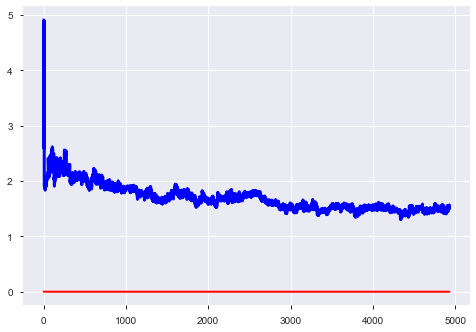

In [96]:
plot_learning_curves(tree_reg, wind_prepared, wind_df_labels)

Over-fitting!

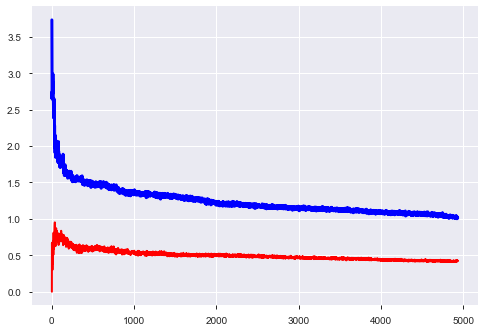

In [97]:
plot_learning_curves(final_model, wind_prepared, wind_df_labels)

Good bias-variance trade off!

### Un solo predictor: la velocidad del viento
<a id="wind-vel-only"></a>

Probaremos una regresión polinomial, habida cuenta de la relación cúbica entre la potencia y la velocidad del viento.

In [72]:
X = wind_df.w_vel
y = wind_df_labels

X = np.array(X.values)
X = np.reshape(X,(-1,1))
y = np.array(y.values)

In [73]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [74]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(0.5181958374790891, array([-0.38408262,  0.09131639, -0.00258944]))

In [75]:
X_test = wind_test.w_vel
y_test = wind_test_labels

X_test = np.array(X_test.values)
X_test = np.reshape(X_test,(-1,1))
y_test = np.array(y_test.values)

X_test_poly = poly_features.fit_transform(X_test)

In [76]:
y_pred = lin_reg.predict(X_test_poly)


In [77]:
arr = np.concatenate((np.array(y_test), y_pred)).reshape(49,2)

df =  pd.DataFrame(data=arr,
                   index=test.time,
                   columns=['real-production','pred-production'])



In [78]:
get_cape(y_test, y_pred)

21.754609598641967

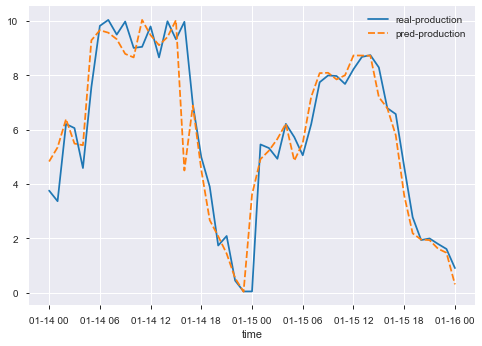

In [79]:
ax = sns.lineplot(data=df)

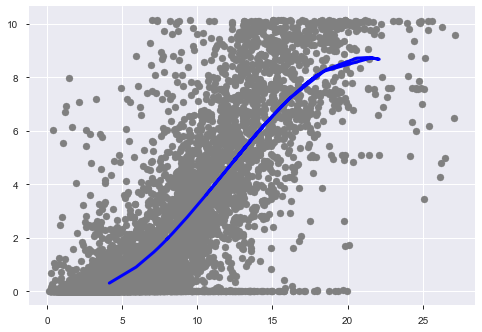

In [80]:
# gráfico del ajuste polinomial a los datos de entrenamiento
plt.scatter(wind_df.w_vel, wind_df_labels,  color='grey')
plt.plot(X_test, y_pred, color='blue', linewidth=3)